In [2]:
import numpy as np
import pandas as pd
import os
import zipfile
import xarray as xr
import shutil
from tqdm import tqdm
import glob

In [ ]:
# # 未使用
# def get_gridCenter(degree,n):
#     n1 = n/2
#     degree = degree-np.sign(degree)*n1

#     minm = np.sign(degree//n)*(abs(degree//n) * n + n1) 
#     # print(minm)
#     center = minm+n1

#     return center

In [ ]:
# 从一个按时间段完整合并的era5.nc中截取一个站点时间段完整的7*7的era5_ssm.nc
# 并分别存到对应站名所在的文件夹下
# 截取的数据为7*7的格点数据，时段为自选
nan_points = []
n = 0
nc = xr.open_dataset(r"D:\dataset\ERA5_yellow\era5_ssm.nc")
nc = nc['swvl1']

all_station_path = 'D:\dataset\mutifusion_sta_data\ismn_sites'
all_station_files = os.listdir(all_station_path)
for station_file in all_station_files:
    station_file_path = os.path.join(all_station_path, station_file)
    intro_list =  glob.glob(station_file_path + '\\*_intro.txt')
    df = pd.read_csv(intro_list[0])
    # 如果想从intro读取站点的经纬度、气候、土地覆盖类型，可以使用下面的代码
    # df = pf.read_csv('intor.txt')
    # climate_KG = df[df['variable']=='climate_KG']['data'].values[0]
    # lc_2000 = df[df['variable']=='lc_2000']['data'].values[0]
    # lon = df[df['variable']=='longitude']['data'].values[0]
    # lat = df[df['variable']=='latitude']['data'].values[0]
    lat = float(df[df['variable']=='latitude']['data'].values[0])
    lon = float(df[df['variable']=='longitude']['data'].values[0])
    print(lat,lon)

    olat,olon = nc.latitude.data,nc.longitude.data
    # 直接找最近的中心索引
    # centerlon_index,centerlat_index = np.argmin(abs(olon-centerlon)),np.argmin(abs(olat-centerlat))
    centerlon_index,centerlat_index = np.argmin(abs(olon-lon)),np.argmin(abs(olat-lat))

    lon_range = olon[centerlon_index-3:centerlon_index+4]
    lat_range = olat[centerlat_index-3:centerlat_index+4]
    
    # 截取变量类型
    # nc = nc['swvl1']
    # 此处可以修改截取时段
    # nc_30 = nc.loc['2001-1-1':'2020-1-1']
    print(nc.shape)
    nc_30 = nc.loc[:]
    print(nc_30.shape)
    # 7*7
    nc_coordinate = nc_30.sel(longitude=lon_range, latitude=lat_range)
    #print(nc_coordinate['time'])

    ############################
    print(nc_coordinate.shape)
    if nc_coordinate.shape[1]!=7 or nc_coordinate.shape[2]!=7:
        print(nc_coordinate.shape,centerlon_index,len(olon),centerlat_index,len(olat))
        # n+=1
        continue
    elif nc_coordinate.isnull().sum().sum()>0:
        print(nc_coordinate.isnull().sum().sum())
        print(station_file)
        nan_points.append(station_file)
        # n+=1
        continue
    ############################
    
    cut = xr.Dataset({'swvl1': nc_coordinate})
    last_dir = station_file_path + "\\era5_ssm.nc"
    cut.to_netcdf(last_dir)
    print('try cut.to_netcdf(last_dir)'+str(n))
    n+=1

In [ ]:
# 检查前述截取的era5_ssm.nc文件是否有问题

nc = xr.open_dataset(r"D:\dataset\mutifusion_sta_data\ismn_sites\CST-01\era5_ssm.nc")
#取出各variable的数据看看,数据格式为numpy数组
for var in nc.variables.keys():
    data=nc.variables[var][:].data
    print(var,data.shape)
#     np.save(var+'.npy',data)

In [2]:
# 根据每个站点自己的标签，从每个站点的era5_ssm.nc中做30天的滑动窗口
# 输出1：每个站点最大限度的30天的滑动窗口【也就是标签数】成npy存储到站名文件夹下
# 输出2：所有站点数据按照object保存不等长npy方法，合并到ismn_merged_npy文件夹下
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import os
import zipfile
import xarray as xr
import shutil
from tqdm import tqdm
import glob

# 输入 ISMN 数据和 ERA5 数据，输出滑动窗口大小为window_size的数据
def get_era5_window_data(ismn_data, era5_data, output_path, window_size):
    # 创建一个空的数组来存储提取的数据
    extracted_data = [] 
    # 遍历 ISMN 数据
    for _, row in ismn_data.iterrows():
        date_time = row['date_time']
        soil_moisture = row['soil_moisture']

        # 检查 soil_moisture 是否为非空值
        if not pd.isnull(soil_moisture):
            # 提取对应日期前xx天的 ERA5 数据
            start_date = date_time - timedelta(days=window_size)
            end_date = date_time
            # print(start_date,' ',end_date)
            
            #sel是左闭右开的，所有这里取了标签前xx天的数据，标签为当天的数据
            era5_subset = era5_data.sel(time=slice(start_date, end_date))
            # print(era5_subset['swvl1'].values.shape)
            '''
            正确输出(以window=2为例)：
            2008-05-11 00:00:00   2008-05-13 00:00:00
            (2, 7, 7)
            '''
            
            # 将 ERA5 数据添加到提取的数据列表中           
            extracted_data.append(era5_subset['swvl1'].values)

    # 将提取的数据转换为 NumPy 数组
    # 刚保存的时候就要dtype=object
    print('转换前：',type(extracted_data))
    #extracted_data = np.asarray(extracted_data,dtype=object)
    print('list-size(每个站点标签个数):',len(extracted_data))
    # 保存提取的数据为.npy文件
    # 每个站点文件夹下保存的自己的是numpy格式

    # 如果要重新保存，就取消下面的注释
    # 【注意】如果保存文件没有报错，那就说明label是可以正常获取前xx天的数据的;如果报错，那就按照smap修改
    # np.save('%s/era5_ssm_%d.npy'%(output_path,window_size), extracted_data)
    print(f'提取的数据已保存为 extracted_data.npy')
    # 返回给等下要合并的，内部数据是float32格式【好像无所谓】
    ready_to_merged = np.asarray(extracted_data,dtype=np.float32)
    print('转换后：',type(ready_to_merged))
    return ready_to_merged

all_station_path = 'D:\dataset\mutifusion_sta_data\ismn_sites'
all_station_files = os.listdir(all_station_path)

merged_data = []
for station_file in all_station_files:
    station_file_path = os.path.join(all_station_path, station_file)
    # 读取 ISMN 数据
    ismn_data = pd.read_csv(os.path.join(station_file_path,'ismn.csv'), parse_dates=['date_time'])
    # 读取 ERA5 数据
    era5_data = xr.open_dataset(os.path.join(station_file_path,'era5_ssm.nc'))

    # 提取滑动窗口大小为30天的数据
    # 当extracted_data为list的时候就给他们合并起来
    merged_data.append(get_era5_window_data(ismn_data, era5_data,station_file_path,window_size=30))
    print('merged_data-size:',len(merged_data))

# 将提取的数据转换为 NumPy 数组
# 内部数据是object格式【核心！这样才能保存不等长】
merged_data = np.asarray(merged_data,dtype=object)

# 保存提取的数据为.npy文件
# 目标文件夹路径
output_folder = r'D:\dataset\mutifusion_sta_data\ismn_merged_npy'
output_file_path = os.path.join(output_folder, 'era5_ssm_stack_30.npy')

# 如果要重新保存，就取消下面的注释
# np.save(output_file_path, merged_data)
# print(f'合并后的era5_ssm_stack_30.npy数据已保存为 {output_file_path}')


转换前： <class 'list'>
list-size(每个站点标签个数): 1366
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 1
转换前： <class 'list'>
list-size(每个站点标签个数): 1362
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 2
转换前： <class 'list'>
list-size(每个站点标签个数): 2140
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 3
转换前： <class 'list'>
list-size(每个站点标签个数): 2433
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 4
转换前： <class 'list'>
list-size(每个站点标签个数): 3168
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 5
转换前： <class 'list'>
list-size(每个站点标签个数): 238
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 6
转换前： <class 'list'>
list-size(每个站点标签个数): 268
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 7
转换前： <class 'list'>
list-size(每个站点标签个数): 451
提取的数据已保存为 extracted_data.npy
转换后： <class 'numpy.ndarray'>
merged_data-size: 8
转换前： <class

In [5]:
# 验证era5不等长合并有效性
# 35指的是站点个数
# (1366，30，7，7)指的是某个站点内有效标签数对应的滑动裁剪的数据
# 输出为这样是正确的
'''
<class 'numpy.ndarray'>
(35,)
<class 'numpy.ndarray'>
(1366, 30, 7, 7)
'''

import numpy as np
test_npy_cut = np.load(r"D:\dataset\mutifusion_sta_data\ismn_merged_npy\era5_ssm_stack_30.npy",allow_pickle=True)
print(type(test_npy_cut))
print(test_npy_cut.shape)
print(type(test_npy_cut[0]))
print(test_npy_cut[0].shape)


<class 'numpy.ndarray'>
(35,)
<class 'numpy.ndarray'>
(1366, 30, 7, 7)


In [3]:
# 输入ismn.csv文件
# 输出非空的ismn.npy文件，当作label
import pandas as pd
import numpy as np

merged_data = []

all_station_path = 'D:\dataset\mutifusion_sta_data\ismn_sites'
all_station_files = os.listdir(all_station_path)
for station_file in all_station_files:
    station_file_path = os.path.join(all_station_path, station_file)
    # 读取 ISMN 数据
    ismn_data = pd.read_csv(os.path.join(station_file_path,'ismn.csv'), parse_dates=['date_time'])

    # 筛选非空的 soil_moisture 值
    non_empty_soil_moisture = ismn_data['soil_moisture'].dropna()

    # 将非空的 soil_moisture 值保存为一维的 NumPy 数组
    soil_moisture_values = non_empty_soil_moisture.values

    print('转换前：',type(soil_moisture_values))
    print(soil_moisture_values.shape)
    soil_moisture_values = np.array(soil_moisture_values,dtype='float32').reshape(-1,1)
    print('转换后',type(soil_moisture_values))
    # 保存一维数组为.npy文件
    np.save('%s/ismn.npy'%(station_file_path), soil_moisture_values)
    print(f'非空的 soil_moisture 值已保存为 soil_moisture_values.npy')
    
    merged_data.append(soil_moisture_values)

# 内部数据是object格式【核心！这样才能保存不等长】
merged_data = np.asarray(merged_data,dtype=object)

# 保存提取的数据为.npy文件
# 目标文件夹路径
output_folder = r'D:\dataset\mutifusion_sta_data\ismn_merged_npy'
output_file_path = os.path.join(output_folder, 'ismn_stack.npy')
np.save(output_file_path, merged_data)
print(f'合并后的ismn_stack.npy数据已保存为 {output_file_path}')

转换前： <class 'numpy.ndarray'>
(1366,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(1362,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(2140,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(2433,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(3168,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(238,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(268,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(451,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 soil_moisture_values.npy
转换前： <class 'numpy.ndarray'>
(2989,)
转换后 <class 'numpy.ndarray'>
非空的 soil_moisture 值已保存为 so

In [4]:
# 验证ismn不等长合并有效性
# 35指的是站点个数
# (1366,)指的是某个站点内有效标签数
# 输出为这样是正确的
'''
<class 'numpy.ndarray'>
(35,)
<class 'numpy.ndarray'>
(1366,)
'''
import numpy as np
test_npy_cut = np.load(r"D:\dataset\mutifusion_sta_data\ismn_merged_npy\ismn_stack.npy",allow_pickle=True)
print(type(test_npy_cut))
print(test_npy_cut.shape)
print(type(test_npy_cut[0]))
print(test_npy_cut[0].shape)


<class 'numpy.ndarray'>
(35,)
<class 'numpy.ndarray'>
(1366, 1)


In [ ]:
# # 【注意】已废弃，合并操作已整合到上面的代码中
# # 合并每个站点的ismn.npy文件为一个总的ismn.npy文件

# import os
# import numpy as np

# # 源文件夹路径
# source_folder = r'D:\dataset\mutifusion_sta_data\ismn_sites'

# # 目标文件夹路径
# output_folder = r'D:\dataset\mutifusion_sta_data\ismn_merged_npy'

# # 创建目标文件夹（如果不存在）
# os.makedirs(output_folder, exist_ok=True)

# # 初始化一个空的数组来存储合并后的数据
# merged_data = []

# # 遍历源文件夹中的每个子文件夹
# for subdir in os.listdir(source_folder):
#     subdir_path = os.path.join(source_folder, subdir)
    
#     # 检查子文件夹中是否存在ismn.npy文件
#     if os.path.isdir(subdir_path) and 'ismn.npy' in os.listdir(subdir_path):
#         ismn_file_path = os.path.join(subdir_path, 'ismn.npy')
        
#         # 读取ismn.npy文件并将其合并到merged_data中
#         ismn_data = np.load(ismn_file_path)
#         merged_data.append(ismn_data)

# # 合并所有数据
# if merged_data:
#     merged_data = np.concatenate(merged_data, axis=0)
    
#     # 保存合并后的数据为npy文件到目标文件夹
#     output_file_path = os.path.join(output_folder, 'ismn.npy')
#     np.save(output_file_path, merged_data)
#     print(f'合并后的ismn数据已保存为 {output_file_path}')
# else:
#     print('没有找到任何ismn.npy文件进行合并。')


In [ ]:
# #【注意】已废弃，合并操作已整合到切片操作中
# # 合并每个站点的era5_ssm_30.npy文件为一个总的era5_ssm_30.npy文件

# import os
# import numpy as np

# # 源文件夹路径
# source_folder = r'D:\dataset\mutifusion_sta_data\ismn_sites'

# # 目标文件夹路径
# output_folder = r'D:\dataset\mutifusion_sta_data\ismn_merged_npy'

# # 创建目标文件夹（如果不存在）
# os.makedirs(output_folder, exist_ok=True)

# # 初始化一个空的数组来存储合并后的数据
# merged_data = []

# # 遍历源文件夹中的每个子文件夹
# for subdir in os.listdir(source_folder):
#     subdir_path = os.path.join(source_folder, subdir)
    
#     # 检查子文件夹中是否存在era5_ssm_30.npy文件
#     if os.path.isdir(subdir_path) and 'era5_ssm_30.npy' in os.listdir(subdir_path):
#         ismn_file_path = os.path.join(subdir_path, 'era5_ssm_30.npy')
        
#         # 读取era5_ssm_30.npy文件并将其合并到merged_data中
#         # allow_pickle=True 才能读取object类型的数据
#         ismn_data = np.load(ismn_file_path, allow_pickle=True)
#         print(type(ismn_data))
#         # 数据类型设置为object,才能合并为不等长npy文件
#         ismn_data.astype(object)
#         print(type(ismn_data))
#         print('ismn_data.shape',ismn_data.shape)
#         merged_data.append(ismn_data)
#         print('merged_data.shape',len(merged_data))
#         # merged_data = np.stack([merged_data,ismn_data],axis=0)

# # 合并所有数据
# if merged_data:
#     #merged_data = np.concatenate(merged_data, axis=0)
    
#     # 保存合并后的数据为npy文件到目标文件夹
#     output_file_path = os.path.join(output_folder, 'era5_ssm_stack_30.npy')
#     np.save(output_file_path, merged_data)
#     print(f'合并后的era5_ssm_30数据已保存为 {output_file_path}')
# else:
#     print('没有找到任何era5_ssm_30.npy文件进行合并。')


In [ ]:
# # 【注意】未使用
# # 标准化npy文件
# # 输入ismn.npy/era5_ssm_30.npy文件
# # 输出标准化后的ismn.npy/era5_ssm_30.npy文件
# import numpy as np

# # 读取 NumPy 数组
# data_1 = np.load(r'D:\dataset\mutifusion_sta_data\ismn_merged_npy\ismn.npy')

# # 计算数据的均值和标准差
# mean = np.mean(data_1, axis=0)
# std = np.std(data_1, axis=0)

# # 标准化数据
# normalized_data = (data - mean) / std

# # 将标准化后的数据保存为新的 NumPy 文件
# np.save(r'D:\dataset\mutifusion_sta_data\ismn_merged_npy\normalized\ismn.npy', normalized_data)

# ####################################################################################
# # 读取 NumPy 数组
# data = np.load(r'D:\dataset\mutifusion_sta_data\ismn_merged_npy\era5_ssm_30.npy')

# # 计算数据的均值和标准差
# mean = np.mean(data, axis=0)
# std = np.std(data, axis=0)

# # 标准化数据
# normalized_data = (data - mean) / std

# # 将标准化后的数据保存为新的 NumPy 文件
# np.save(r'D:\dataset\mutifusion_sta_data\ismn_merged_npy\normalized\era5_ssm_30.npy', normalized_data)


In [6]:
# 站名和index对应输出
# 结合K折训练验证集划分
import os

all_station_path = 'D:\dataset\mutifusion_sta_data\ismn_sites'
all_station_files = os.listdir(all_station_path)
index = 0
for station_file in all_station_files:
    print(index,' ',station_file)
    index+=1

0   CST-01
1   CST-02
2   CST-03
3   CST-04
4   CST-05
5   GUYUAN
6   HUANXIAN
7   LUSHI
8   NST-01
9   NST-02
10   NST-03
11   NST-04
12   NST-05
13   NST-06
14   NST-07
15   NST-08
16   NST-09
17   NST-10
18   NST-11
19   NST-12
20   NST-13
21   NST-14
22   NST-15
23   NST-21
24   NST-22
25   NST-24
26   NST-25
27   NST-30
28   NST-31
29   NST-32
30   TIANSHUI
31   TONGWEI
32   XIFENGZH
33   XINXIAN
34   YONGNING


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.activation as activation

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        scores = torch.matmul(query, key.transpose(1, 2))
        attention_weights = F.softmax(scores, dim=-1)
        print('attention_weights.shape',attention_weights.shape)
        
        weighted_value = torch.matmul(attention_weights, value)
        output = torch.sum(weighted_value, dim=1)
        print('output.shape',output.shape)
        
        return output

class SoilHumidityPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SoilHumidityPredictor, self).__init__()
        self.attention = SelfAttention(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, feature1, feature2, feature3):
        weighted_feature1 = self.attention(feature1)
        weighted_feature2 = self.attention(feature2)
        weighted_feature3 = self.attention(feature3)

        combined_features = torch.cat([weighted_feature1, weighted_feature2, weighted_feature3], dim=-1)

        output = self.mlp(combined_features)

        return output

# 创建模型
input_dim = 32  # 输入特征维度
hidden_dim = 64  # 隐藏层维度
output_dim = 1  # 输出维度（土壤湿度值）

# model = SoilHumidityPredictor(input_dim, hidden_dim, output_dim)
model = activation.MultiheadAttention(input_dim, 1)

# 创建随机特征向量示例
batch_size = 1  # 批次大小
feature1 = torch.randn(batch_size, 32)  # 第一个特征向量
feature2 = torch.randn(batch_size, 32)  # 第二个特征向量
feature3 = torch.randn(batch_size, 32)  # 第三个特征向量

# 使用模型进行预测
output = model(feature1, feature2, feature3)

print("预测的土壤湿度值:", output)


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [6]:
import torch
import torch.nn as nn

# 定义输入维度和注意力头的数量
input_dim = 32  # 输入特征维度
num_heads = 1  # 注意力头的数量

# 初始化 MultiheadAttention 层
multihead_attention = nn.MultiheadAttention(input_dim, num_heads)

# 创建示例输入数据
batch_size = 1  # 批次大小
seq_len = 30  # 序列长度
input_data = torch.randn(seq_len, batch_size, input_dim)  # 输入数据的形状为 (seq_len, batch_size, input_dim)

# 计算多头自注意力
output, attention_weights = multihead_attention(input_data, input_data, input_data)

# 输出结果形状为 (seq_len, batch_size, input_dim)，表示多头自注意力的输出
print("多头自注意力输出的形状:", output.shape)

# 注意力权重形状为 (batch_size, num_heads, seq_len, seq_len)，表示每个注意力头的注意力权重
print("注意力权重的形状:", attention_weights.shape)


多头自注意力输出的形状: torch.Size([30, 1, 32])
注意力权重的形状: torch.Size([1, 30, 30])


多头自注意力输出的形状: torch.Size([128, 30, 36])
注意力权重的形状: torch.Size([128, 30, 30])


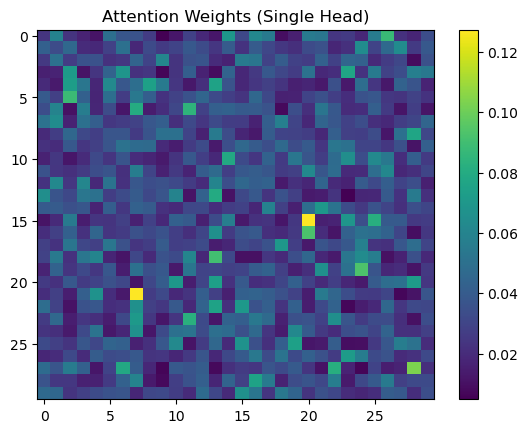

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 定义输入维度和注意力头的数量
input_dim = 36  # 输入特征维度
num_heads = 1  # 注意力头的数量

# 初始化 MultiheadAttention 层
multihead_attention = nn.MultiheadAttention(input_dim, num_heads,batch_first=True)

# 创建示例输入数据
batch_size = 128  # 批次大小
seq_len = 30  # 序列长度
input_data_1 = torch.randn(batch_size,seq_len,  input_dim)  # 输入数据的形状为 (seq_len, batch_size, input_dim)
input_data_2 = torch.randn(batch_size,seq_len,  input_dim)  # 输入数据的形状为 (seq_len, batch_size, input_dim)
input_data_3 = torch.randn(batch_size,seq_len,  input_dim)  # 输入数据的形状为 (seq_len, batch_size, input_dim)



# 计算多头自注意力
output, attention_weights = multihead_attention(input_data_1, input_data_2, input_data_3)
# 输出结果形状为 (seq_len, batch_size, input_dim)，表示多头自注意力的输出
print("多头自注意力输出的形状:", output.shape)

# 注意力权重形状为 (batch_size, num_heads, seq_len, seq_len)，表示每个注意力头的注意力权重
print("注意力权重的形状:", attention_weights.shape)
# 注意力权重形状为 (seq_len, batch_size, num_heads, seq_len)，需要将其调整为 (seq_len, seq_len)
attention_weights = attention_weights.squeeze(0).cpu().detach().numpy()

# 可视化注意力权重
plt.imshow(attention_weights[1], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Attention Weights (Single Head)')
plt.show()
